**Load Libraries**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

**Load Dataset**

In [11]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
file_path = '/content/drive/MyDrive/Kubernetes_Guidewire Hackathon/kubernetes_metrics_dataset.csv'
# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Kubernetes_Guidewire Hackathon/kubernetes_metrics_dataset.csv")

# Convert Timestamp to datetime (if needed)
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# Drop Timestamp column (not needed for training)
df.drop(columns=["Timestamp"], inplace=True)

Mounted at /content/drive


**Data Preprocessing**

In [14]:
# Encode categorical variable (Pod_Status)
label_encoder = LabelEncoder()
df["Pod_Status"] = label_encoder.fit_transform(df["Pod_Status"])  # e.g., Running → 1, Failed → 0

# Define features (X) and target variable (y)
X = df.drop(columns=["Issue_Label"])  # Features (CPU, Memory, Disk, etc.)
y = df["Issue_Label"]  # Target (0 = No Issue, 1 = Issue)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Train & Evaluate Random Forest Model**

In [15]:
# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred = rf_model.predict(X_test)

# Model Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Model Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       863
           1       1.00      1.00      1.00      1137

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Confusion Matrix:
 [[ 862    1]
 [   0 1137]]


**Feature Importance Visualization**

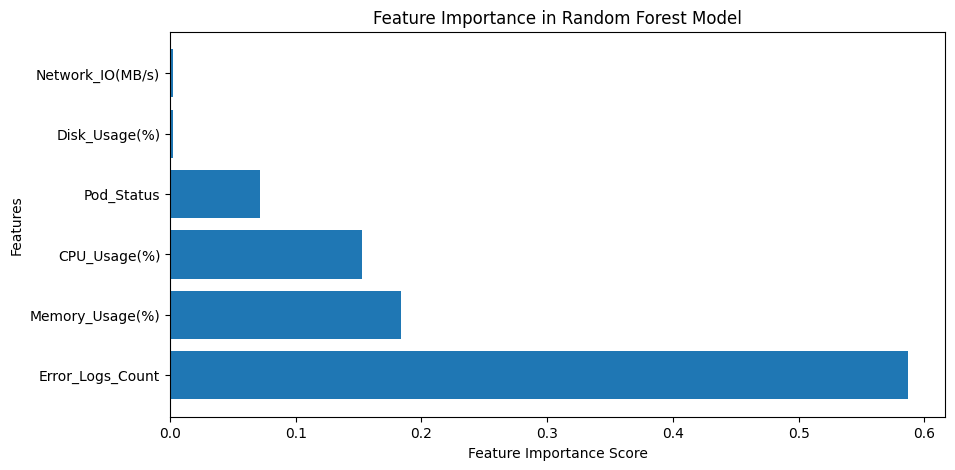

In [16]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = rf_model.feature_importances_

# Convert to DataFrame for better visualization
importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest Model")
plt.show()

**Hyperparameter Tuning (RandomizedSearchCV)**

In [17]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [18]:
# Define the parameter grid
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20,  # Number of random combinations to try
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all CPU cores
)

# Fit the model
random_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:", random_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10}


**Train & Evaluate Optimized Model**

In [19]:
# Use the best parameters from tuning
best_params = random_search.best_params_

# Train Random Forest with optimized parameters
best_rf_model = RandomForestClassifier(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Evaluate Performance
y_pred_best = best_rf_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Optimized Model Accuracy:", accuracy_best)

Optimized Model Accuracy: 0.9995


**Handling Class Imbalance**

In [23]:
from collections import Counter
from imblearn.over_sampling import SMOTE

# Check class distribution before balancing
print("Class distribution before SMOTE:", Counter(y_train))

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check class distribution after balancing
print("Class distribution after SMOTE:", Counter(y_train_balanced))


Class distribution before SMOTE: Counter({1: 4547, 0: 3453})
Class distribution after SMOTE: Counter({1: 4547, 0: 4547})


**Training an Alternative Model: XGBoost**

In [24]:
from xgboost import XGBClassifier

# Initialize XGBoost model
xgb_model = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.05, random_state=42)

# Train on balanced dataset
xgb_model.fit(X_train_balanced, y_train_balanced)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)

# Print Accuracy
print("XGBoost Model Accuracy:", accuracy_score(y_test, y_pred_xgb))

# Print Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

# Print Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


XGBoost Model Accuracy: 0.9975
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       863
           1       1.00      1.00      1.00      1137

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Confusion Matrix:
 [[ 862    1]
 [   4 1133]]


**Feature Explainability with SHAP**

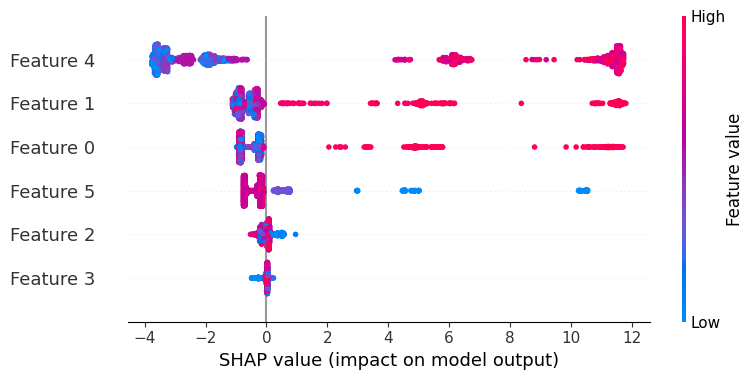

In [25]:
import shap

# Create SHAP explainer
explainer = shap.Explainer(xgb_model, X_train_balanced)
shap_values = explainer(X_test)

# Summary Plot
shap.summary_plot(shap_values, X_test)

**Model Comparison: XGBoost vs. Random Forest**

In [26]:
import time

# Time the RF Model
start = time.time()
rf_pred = best_rf_model.predict(X_test)
rf_time = time.time() - start

# Time the XGBoost Model
start = time.time()
xgb_pred = xgb_model.predict(X_test)
xgb_time = time.time() - start

# Print Accuracy and Processing Time
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print("Random Forest Processing Time:", rf_time, "seconds")

print("XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))
print("XGBoost Processing Time:", xgb_time, "seconds")


Random Forest Accuracy: 0.9995
Random Forest Processing Time: 0.050649166107177734 seconds
XGBoost Accuracy: 0.9975
XGBoost Processing Time: 0.006183624267578125 seconds


**Saving the Models**

In [27]:
import joblib

# Save Random Forest model
joblib.dump(rf_model, "random_forest.pkl")

# Save XGBoost model
joblib.dump(xgb_model, "xgboost.pkl")


['xgboost.pkl']

**Download Models Locally**

In [ ]:
from google.colab import files

files.download("random_forest.pkl")
files.download("xgboost.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Save SHAP Values & Feature Importance**

In [ ]:
import numpy as np

# Save SHAP values as a NumPy array
np.save("shap_values.npy", shap_values)

# Download file
files.download("shap_values.npy")

import pandas as pd

# Get feature names from the original DataFrame (df) before preprocessing
feature_names = df.drop(columns=["Issue_Label"]).columns  # Assuming 'df' is your original DataFrame

feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': rf_model.feature_importances_})

# Save to CSV
feature_importance.to_csv("feature_importance_rf.csv", index=False)

# Download the file (for Colab users)
files.download("feature_importance_rf.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Test Data Summary & Distribution**

This section provides insights into the test dataset used for evaluation. It includes:
- The total number of samples in the test set.
- The class distribution after SMOTE.
- A preview of the test data.

In [28]:
# Test data size
print("Test Data Size:", X_test.shape)

# Check class distribution in test data
from collections import Counter
print("Class distribution in test data:", Counter(y_test))

# Display sample test data
print("\nSample Test Data:\n", X_test[:5])


Test Data Size: (2000, 6)
Class distribution in test data: Counter({1: 1137, 0: 863})

Sample Test Data:
 [[ 0.99679384 -0.05960675  0.31585158 -0.37401784  1.56865582  0.1336261 ]
 [-1.52993968  1.36521473  0.42650115  0.35275316 -0.88120686  0.1336261 ]
 [-0.58387204 -0.51156808  1.61755461 -1.59110354 -1.58116762  0.1336261 ]
 [ 1.11520956  0.47422014  1.4361228  -0.943301   -1.23118724 -2.7871629 ]
 [-1.37129743 -0.48399491 -1.34932912  1.19443876  1.21867544  0.1336261 ]]


**Model Evaluation & Performance Insights**

This section evaluates the trained models using accuracy, confusion matrices, and feature importance.


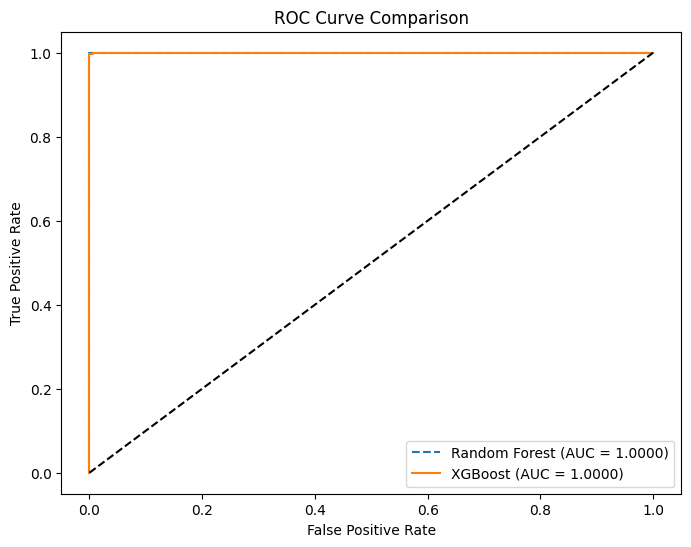

Random Forest Confusion Matrix:


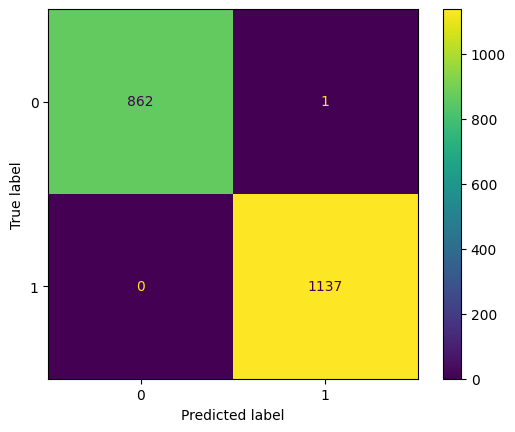

XGBoost Confusion Matrix:


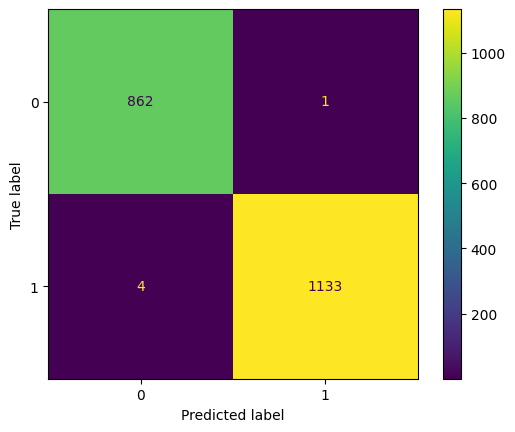

In [29]:
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute ROC curve and AUC for Random Forest
y_prob_rf = best_rf_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = auc(fpr_rf, tpr_rf)

# Compute ROC curve and AUC for XGBoost
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.4f})", linestyle="--")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.4f})")
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

# Confusion Matrix for Random Forest
print("Random Forest Confusion Matrix:")
ConfusionMatrixDisplay.from_estimator(best_rf_model, X_test, y_test)
plt.show()

# Confusion Matrix for XGBoost
print("XGBoost Confusion Matrix:")
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test)
plt.show()


**Testing on Different Dataset**

In [12]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load test dataset
test_file_path = "/content/drive/MyDrive/Kubernetes_Guidewire Hackathon/Kubernetes_test_f.csv"  # Change path if needed
test_data = pd.read_csv(test_file_path)

# Drop the Timestamp column (not needed for predictions)
test_data_cleaned = test_data.drop(columns=["Timestamp"])

# Encode categorical feature (Pod_Status)
label_encoder = LabelEncoder()
test_data_cleaned["Pod_Status"] = label_encoder.fit_transform(test_data_cleaned["Pod_Status"])

# Separate features (X) and target (y)
X_test_final = test_data_cleaned.drop(columns=["Issue_Label"])  # Features
y_test_final = test_data_cleaned["Issue_Label"]  # True labels (for evaluation)

# Apply StandardScaler (Assuming the same scaler was used in training)
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test_final)

# Display processed test data
print("Processed Test Data (First 5 Rows):")
print(pd.DataFrame(X_test_scaled, columns=X_test_final.columns).head())


Processed Test Data (First 5 Rows):
   CPU_Usage(%)  Memory_Usage(%)  Disk_Usage(%)  Network_IO(MB/s)  \
0     -1.371454         1.066186      -1.334455         -0.082577   
1      0.810937         0.458120       0.918956         -0.788976   
2      0.694036        -0.383087      -0.795374          0.571198   
3     -1.402380        -0.142797       0.593905         -0.438749   
4      1.527917         0.703747       0.753547         -0.965294   

   Error_Logs_Count  Pod_Status  
0          1.581083    0.119377  
1         -0.157813   -2.811586  
2         -0.505592    0.119377  
3         -0.853371    0.119377  
4          0.537746    0.119377  


In [30]:
# Run predictions using trained models
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate accuracy
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Random Forest Accuracy on New Test Data:", accuracy_score(y_test_final, y_pred_rf))
print("XGBoost Accuracy on New Test Data:", accuracy_score(y_test_final, y_pred_xgb))

# Print detailed classification report
print("\n📊 Classification Report (Random Forest):\n", classification_report(y_test_final, y_pred_rf))
print("\n📊 Classification Report (XGBoost):\n", classification_report(y_test_final, y_pred_xgb))

# Print confusion matrices
print("\n Confusion Matrix - Random Forest:")
print(confusion_matrix(y_test_final, y_pred_rf))

print("\n Confusion Matrix - XGBoost:")
print(confusion_matrix(y_test_final, y_pred_xgb))


Random Forest Accuracy on New Test Data: 0.9880059970014993
XGBoost Accuracy on New Test Data: 0.9330334832583708

📊 Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       897
           1       0.99      0.99      0.99      1104

    accuracy                           0.99      2001
   macro avg       0.99      0.99      0.99      2001
weighted avg       0.99      0.99      0.99      2001


📊 Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       0.99      0.86      0.92       897
           1       0.90      0.99      0.94      1104

    accuracy                           0.93      2001
   macro avg       0.94      0.93      0.93      2001
weighted avg       0.94      0.93      0.93      2001


 Confusion Matrix - Random Forest:
[[ 883   14]
 [  10 1094]]

 Confusion Matrix - XGBoost:
[[ 772  125]
 [   9 1095]]
